This code (will be) set up to generate a forecasted impact map of a specified area.
The area in the example case is Houston, TX
The inundation extent is sourced from the National Water Model forecast. 
Depth model is calculated from the inundation extent and the national 3m DEM
The impact map is calculated from the depth and the CDC SVI scores at the census tract scale. 

In [ ]:
# edit code so that it runs automatically every hour
# use python.12.4 kernel
# THIS IS A WORK IN PROGRESS

## Query the NWM 5 day inundation exent. This section will download it as a shapefile, merge polygons, and prepare for depth calculaiton

In [7]:
# query the NOAA API for the most recent flood predictions
import requests
import geopandas as gpd

# Construct the query URL
# To change the query, you can go to https://maps.water.noaa.gov/server/rest/services/nwm
# Then select the link you want, copy it here, and add /0/query to the end
# e.g. https://link_to_service/0/query
query_url = "https://maps.water.noaa.gov/server/rest/services/nwm/mrf_gfs_5day_max_inundation_extent/MapServer/0/query"
params = {
    'where': '1=1',
    'outFields': '*',
    'outSR': '4326',  # Specify output spatial reference if needed
    'f': 'geojson',  # Request geojson output
    'returnGeometry': 'true'
}
# Make the request
response = requests.get(query_url, params=params)


# Check if the server is running correctly. A response of 500 means there is a server error. 
if response.status_code == 200:
    try:
        # Attempt to convert the response to a GeoDataFrame
        predictions = gpd.GeoDataFrame.from_features(response.json(), crs="EPSG:4326")
        print(predictions.head())
    except ValueError as e:
        # Handle JSON decoding errors
        print(f"Error decoding JSON: {e}")
else:
    # The request failed; print the status code and response text
    print(f"Request failed with status {response.status_code}: {response.text}")



# Convert to GeoDataFrame
predictions = gpd.GeoDataFrame.from_features(response.json(), crs="EPSG:4326")
print(predictions.head())


                                            geometry feature_id  \
0  MULTIPOLYGON (((-99.71073 28.04914, -99.71072 ...     605121   
1  MULTIPOLYGON (((-98.91162 27.26558, -98.91162 ...     325213   
2  MULTIPOLYGON (((-98.91939 27.25465, -98.91949 ...     325213   
3  MULTIPOLYGON (((-98.92015 27.25054, -98.92016 ...     325213   
4  POLYGON ((-98.92160 27.24278, -98.92154 27.241...     325213   

   streamflow_cfs           reference_time              update_time  oid  
0            0.35  2024-07-02 12:00:00 UTC  2024-07-02 18:36:06 UTC    1  
1            8.12  2024-07-02 12:00:00 UTC  2024-07-02 18:36:06 UTC    2  
2            8.12  2024-07-02 12:00:00 UTC  2024-07-02 18:36:06 UTC    3  
3            8.12  2024-07-02 12:00:00 UTC  2024-07-02 18:36:06 UTC    4  
4            8.12  2024-07-02 12:00:00 UTC  2024-07-02 18:36:06 UTC    5  
                                            geometry feature_id  \
0  MULTIPOLYGON (((-99.71073 28.04914, -99.71072 ...     605121   
1  MULTIPOLYG

C:\Users\Lyn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\contextily\tile.py:623: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)
C:\Users\Lyn\AppData\Local\Temp\ipykernel_13204\3224829518.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([round(val, 2) for val in ax.get_xticks()], rotation=45)
C:\Users\Lyn\AppData\Local\Temp\ipykernel_13204\3224829518.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(val, 2) for val in ax.get_yticks()])


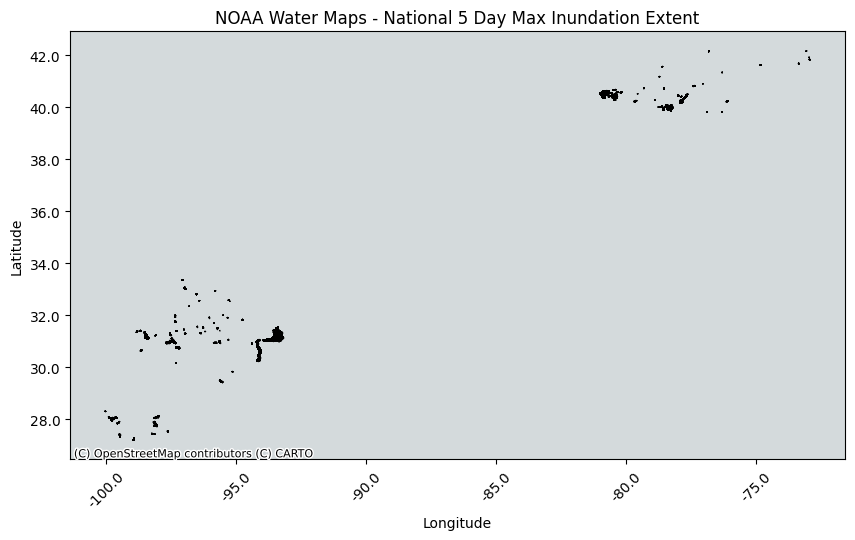

In [2]:
# plot the query results

# Import necessary libraries
import matplotlib.pyplot as plt
import contextily as ctx

# Create a subplot with specified figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictions GeoDataFrame on the created axes object
# Ensure to specify the ax parameter to plot on the same axes
predictions.plot(ax=ax, color='blue', edgecolor='black')

# Add a basemap to the same axes object
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Adjust x and y axis labels to longitude and latitude
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Convert axis labels to degrees and set rotation for better readability
ax.set_xticklabels([round(val, 2) for val in ax.get_xticks()], rotation=45)
ax.set_yticklabels([round(val, 2) for val in ax.get_yticks()])

# Set plot title and labels for axes
plt.title('NOAA Water Maps - National 5 Day Max Inundation Extent')

# Display the combined plot
plt.show()

In [6]:
# clip the predictions to the extent of interest

import geopandas as gpd
import rasterio

infolder = 'C:/Users/Lyn/Documents/Programming/Python_codes/fwdet/Forecast_test_5day/'
dem_name = infolder+'Houston_DEM.tif'
# Open the DEM file with rasterio
with rasterio.open(dem_name) as dem:
    # Read the entire file into a numpy array
    dem_array = dem.read(1)
    # Show the DEM data
    show(dem)

# Clip the predictions GeoDataFrame to the extent of interest
clipped_predictions = gpd.clip(predictions, extent)

NameError: name 'show' is not defined

In [ ]:
# export predictions as a shapefile

from datetime import datetime
# Format the current datetime as a string in the desired format (e.g., YYYYMMDD_HHMMSS)
datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

print(datetime)

# Export GeoDataFrame as a Shapefile
file_name = f"C:/Users/Lyn/Documents/Programming/Python_codes/Impact_Map_Forecasting/results_5day_forecast/5day_inundationextent_{datetime}.shp"
predictions.to_file(file_name)

## FWDET2.1 calculate depth map from inundation extent

In [ ]:
# use kernel arcgispro-py3 (python 3.9.16)
import arcpy

In [ ]:
# set up input and output variables
arcpy.env.overwriteOutput = True
infolder = 'C:/Users/Lyn/Documents/Programming/Python_codes/fwdet/Forecast_test_5day/'

# make a geodatabase    
gdb_path = infolder 
# Create the geodatabase
arcpy.CreateFileGDB_management(out_folder_path = infolder, out_name='geodatabase.gdb')
#workspace
ws = arcpy.env.workspace = infolder

dem_name = infolder+'Houston_DEM.tif'
inund_polygon = infolder+'clipped_extent.shp'
#clip_dem = '' #[Optional] - If empty, the clip_dem will be calculated with the Clip_management function
#cost_raster ='' #[Optional] - If empty, the CostRaster will be calculated below
WaterDepthOutput = 'WaterDepth_i10_s0p5'
iterations = 10
SlopeFiltering = True
SlopeThreshold = 0.5

In [ ]:
# clean and create necessary variables
dem = arcpy.Raster(dem_name)
cell_size = dem.meanCellHeight
# Proper string representation of dem extent to be accepted by Clip_management method
extent = '{} {} {} {}'.format(dem.extent.XMin, dem.extent.YMin, dem.extent.XMax, dem.extent.YMax)

# Dont run these if cost_raster and clip_dem are already defined above
cost_raster = (((dem <= 0)*999)+1)
cost_raster.save('CostRaster.tif')

clip_dem = 'ClipDEM'
arcpy.management.Clip(dem, extent, clip_dem, inund_polygon, nodata_value= "-9999", clipping_geometry="ClippingGeometry", maintain_clipping_extent="NO_MAINTAIN_EXTENT")
clip_dem_ras = arcpy.Raster(clip_dem)

In [ ]:
# debugging - delete later
# check if shapefile has FID field
import arcpy

# Set the path to your polyline feature class
polyline_feature_class = infolder+'polyline.shp'

# List all fields in the feature class
fields = arcpy.ListFields(polyline_feature_class)

# Check if OBJECTID field exists
objectid_exists = any(field.name == "FID" for field in fields)

if not objectid_exists:
    print("FID field does not exist. Consider creating a new feature class.")
    # Here you can add code to create a new feature class or handle the issue as needed.
else:
    print("FID field exists.")

In [ ]:
# Calculate Boundary Raster
print('Focal iteration '+str(i+1))arcpy.env.overwriteOutput = True
polyline = infolder + '/polyline.shp'
arcpy.PolygonToLine_management(inund_polygon, polyline)
# Convert polyline to raster
with arcpy.EnvManager(snapRaster=clip_dem_ras):
    arcpy.conversion.PolylineToRaster(polyline, 'FID', 'linerast15', "MAXIMUM_LENGTH", "NONE", cell_size)
raster_polyline = arcpy.Raster('linerast15')
raster_polyline.save("rstr_poly")
# The input whose values will be used as the output cell values if the condition is false.
inFalseConstant = '#'
where_clause = 'VALUE >= 0'
#Extract the boundary cells elevation from DEM
boundary = arcpy.sa.Con(raster_polyline, dem, inFalseConstant, where_clause)
# boundary.save('boundary1')
#Smooth boundary raster
for i in range(iterations):
    OutRasTemp = arcpy.sa.FocalStatistics(boundary, "Rectangle 5 5 CELL", 'MEAN', 'DATA')
    boundary = arcpy.sa.Con(raster_polyline, OutRasTemp, inFalseConstant, where_clause)
    boundary.save('boundary'+str(i+1))
#Identify and remove ocean boundary cells
OutRasTemp = arcpy.sa.FocalStatistics(dem, 'Circle 2 CELL', 'MINIMUM', 'DATA') 
whereClause2 = 'VALUE > 0'
boundary = arcpy.sa.Con(OutRasTemp, boundary, inFalseConstant, whereClause2)
#boundary.save("boundaryAfterOcean")
if SlopeFiltering:
#calculate topo slope
    print('Calculating Slope')
    extent_clip = '{} {} {} {}'.format(boundary.extent.XMin, boundary.extent.YMin, boundary.extent.XMax, boundary.extent.YMax)
    with arcpy.EnvManager(extent=extent_clip):
        out_slope = arcpy.sa.Slope(dem, "PERCENT_RISE", 1, "GEODESIC", "METER")
        out_slope.save("Slope_m")
#Remove erroneous boundary cells 
    whereClause_slope = 'VALUE > ' + str(SlopeThreshold)
    boundary = arcpy.sa.Con(out_slope, boundary, inFalseConstant, whereClause_slope)
boundary.save("boundFinal")
print('Finished calculating the boundary raster')

In [ ]:
# Calculate water depth 

MULTIPLIER = 10000
boundary_int = arcpy.sa.Int(boundary * MULTIPLIER)
#boundary_int.save("boundary_int")
print('Running cost allocation')
with arcpy.EnvManager(snapRaster=None, extent="DEFAULT", mask=clip_dem):
    cost_alloc = arcpy.sa.CostAllocation(boundary_int, cost_raster, '#', '#', 'Value')

# Divide the result from the cost allocation function using the same constant used to create the integer
# representation of the boundary
cost_alloc = arcpy.sa.Float(cost_alloc) / MULTIPLIER
print('Cost Allocation raster generated')
print('Calculating estimated water depth')
water_depth = (cost_alloc - clip_dem_ras)
# Remove estimated water depths below 0 and change them to 0
water_depth = arcpy.sa.Con(water_depth > 0, water_depth,"#")

In [ ]:
# Run a low-pass filter
# ie smooth the water depth raster
print('Running low-pass Filter')
water_depth_filtered = arcpy.sa.Filter(water_depth, 'LOW', 'DATA')
waterDepthFilter2 = arcpy.sa.Con(clip_dem_ras, water_depth_filtered, '#', 'VALUE > 0')
#waterDepthFilter2.save(WaterDepthOutput+'_filtered')
print('Finished low-pass Filter calculation')
#waterDepthFilter2

Turn the shapefile of the depth map into a raster

In [ ]:
%pip install osgeo

In [ ]:
import os
import geopandas as gpd
from osgeo import gdal, ogr, osr

# Set the working directory
os.chdir(r'C:/Users/Lyn/Documents/Programming/Python_codes/Impact_Map_Forecasting/ results_5day_forecast')

# Read the shapefile using GeoPandas
#shapefile = gpd.read_file(r'D:/Hesham/CUAHSI/Geospatial/Jupyter N2/svi_data.shp')

# Open the shapefile using OGR
#input_shp = ogr.Open(r'D:/Hesham/CUAHSI/Geospatial/Jupyter N2/svi_data.shp')
#source_layer = input_shp.GetLayer()
#defn = source_layer.GetLayerDefn()

# Extract column names
column_names = []
for n in range(predictions.GetFieldCount()):
    fdefn = predictions.GetFieldDefn(n)
    column_names.append(fdefn.GetName())

# Define output raster location and pixel size
output_raster_location = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/svi_raster.tif'
pixel_size = 0.0001

# Get extent of the source layer
xmin, xmax, ymin, ymax = predictions.GetExtent()

# Calculate resolution
x_res = int(round((xmax - xmin) / pixel_size))
y_res = int(round((ymax - ymin) / pixel_size))

# Create the target raster file
target_ds = gdal.GetDriverByName('GTiff').Create(output_raster_location, x_res, y_res, 1, gdal.GDT_Float32, ['COMPRESS=LZW'])
target_ds.SetGeoTransform((xmin, pixel_size, 0, ymax, 0, -pixel_size))

# Set projection
srs = osr.SpatialReference()
srs.ImportFromEPSG(4269)  # EPSG:4269 is NAD83
target_ds.SetProjection(srs.ExportToWkt())

# Get the raster band and set NoData value
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(-9999)
band.Fill(-9999)

# Rasterize the shapefile layer to the raster
gdal.RasterizeLayer(target_ds, [1], source_layer, options=['ALL_TOUCHED=TRUE', 'ATTRIBUTE=SVI'])

# Close the raster dataset
target_ds = None

print("Rasterization complete!")


## Run SVI using depth map